# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [4]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("hot_design_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [5]:
n_chains = 4
n_edges_per_chain = 3
bar_radius = 0.5

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 200, 100, 100

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params.flatten(),
        "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
        "static_parameters": [n_chains, n_edges_per_chain + 1],
        "string_parameters": [],
        "mesh_tesseract": TesseractReference(bar_3d_tess),
        "grid_size": [Lx, Ly, Lz],
        "grid_elements": [Nx, Ny, Nz],
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

ERROR:2025-11-06 19:42:11,145:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH


Number of vertices: 480
Number of faces: 944
SDF shape: (200, 100, 100)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

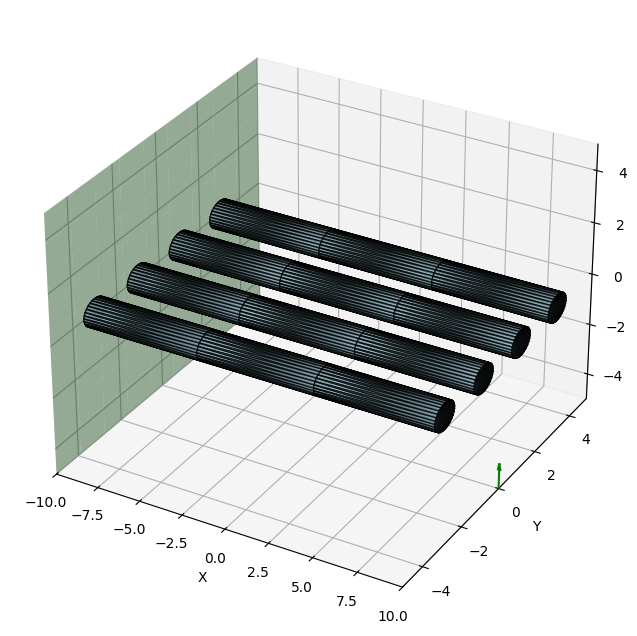

In [6]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

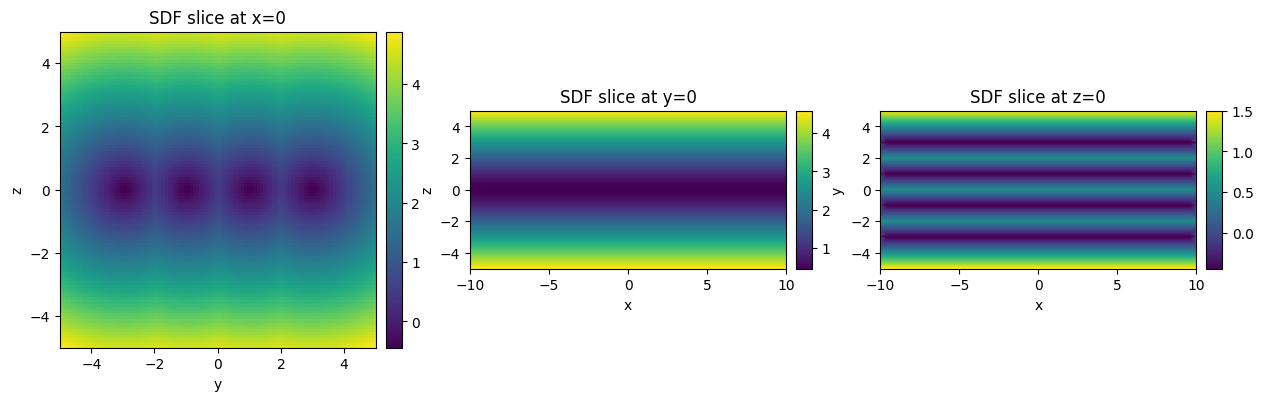

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [8]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params.flatten(),
#             "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
#             "static_parameters": [n_chains, n_edges_per_chain + 1],
#             "string_parameters": [],
#             "mesh_tesseract": TesseractReference(bar_3d_tess),
#             "grid_size": [Lx, Ly, Lz],
#             "grid_elements": [Nx, Ny, Nz],
#             "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
#             "normalize_jacobian": True,
#         },
#     )["sdf"],
#     initial_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [9]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, 0, 6)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     primal, vjp_fun = jax.vjp(
#         lambda params, eps=eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 "non_differentiable_parameters": jnp.array(
#                     [bar_radius], dtype=jnp.float32
#                 ),
#                 "static_parameters": [n_chains, n_edges_per_chain + 1],
#                 "string_parameters": [],
#                 "mesh_tesseract": TesseractReference(bar_3d_tess),
#                 "grid_size": [Lx, Ly, Lz],
#                 "grid_elements": [Nx, Ny, Nz],
#                 "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
#                 "normalize_jacobian": True,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [10]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

rho min: 6.307388684945181e-05, rho max: 0.7282912731170654


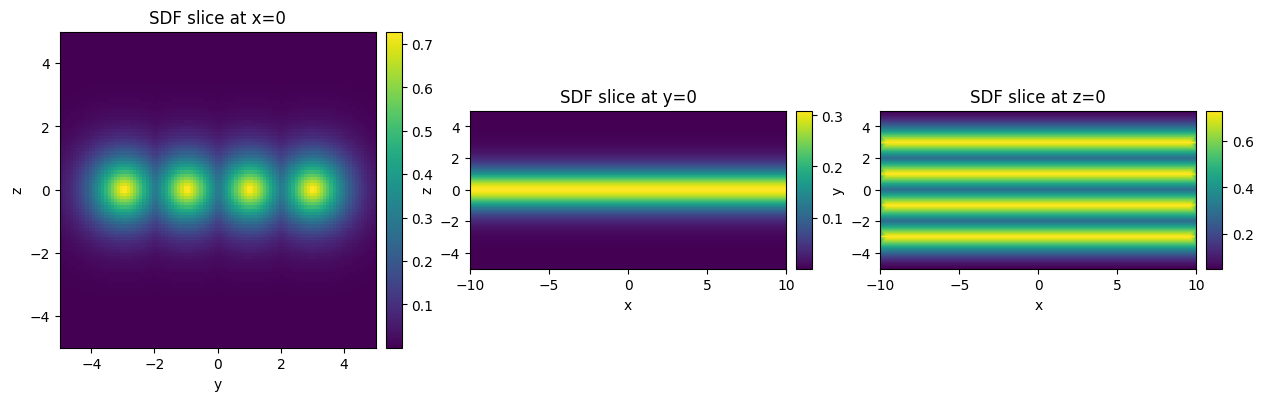

In [11]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.3333333432674408, max: 5.0


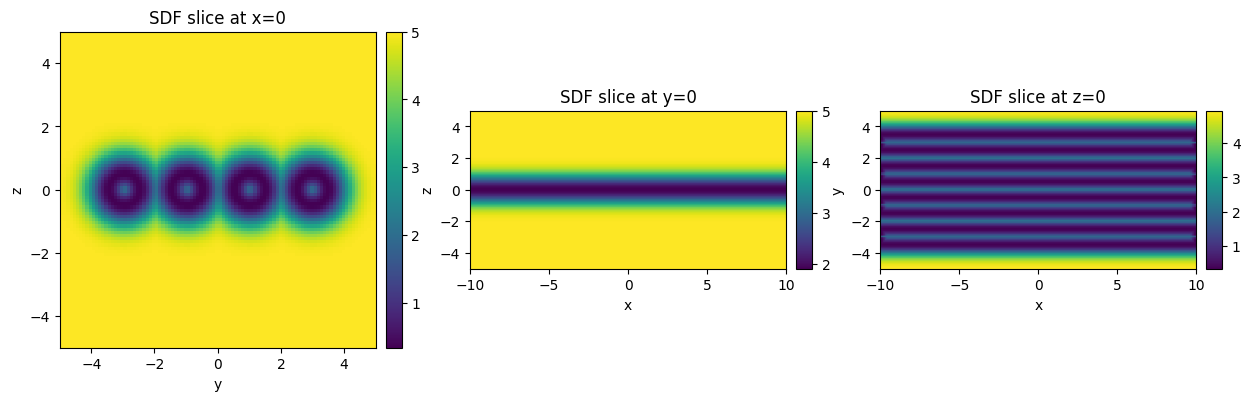

In [12]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 4, scale=2.0)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [13]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        # "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        "sizing_field": jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 4,
        "max_points": 5000,
        "max_cells": 5000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 4913, Mesh faces: 4096


Lets check the gradient of the meshing Tesseract

In [14]:
# max_points = 5000
# max_cells = 5000

# primal, vjp_fun = jax.vjp(
#     lambda rho: apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
#             "field_values": rho,
#             "max_subdivision_levels": 4,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )["mesh_cell_values"],
#     rho,
# )

# grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

# print("Gradient shape:", grad.shape)
# print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [15]:
# # Lets export it to a .vtk using pyvista
# import pyvista as pv


# def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
#     """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

#     Args:
#         pts: Array of point coordinates, shape (N, 3).
#         faces: Array of hexahedral cell connectivity, shape (M, 8).

#     Returns:
#         PyVista mesh representing the hexahedral grid.
#     """
#     # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
#     cell_type = pv.CellType.HEXAHEDRON
#     cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

#     # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
#     n_cells = faces.shape[0]
#     cells = np.empty((n_cells, 9), dtype=np.int64)
#     cells[:, 0] = 8  # Each cell has 8 points
#     cells[:, 1:9] = faces

#     # Flatten the cells array for PyVista
#     cells = cells.flatten()

#     return pv.UnstructuredGrid(cells, cell_types, pts)


# # convert arrays to numpy
# pts_np = np.array(adaptive_mesh["points"])
# cells_np = np.array(adaptive_mesh["faces"])

# hex_mesh = hex_to_pyvista(pts_np, cells_np)

# print(hex_mesh)

# hex_mesh.save("fem_shapeopt_mesh.vtk")

## Boundary Conditions

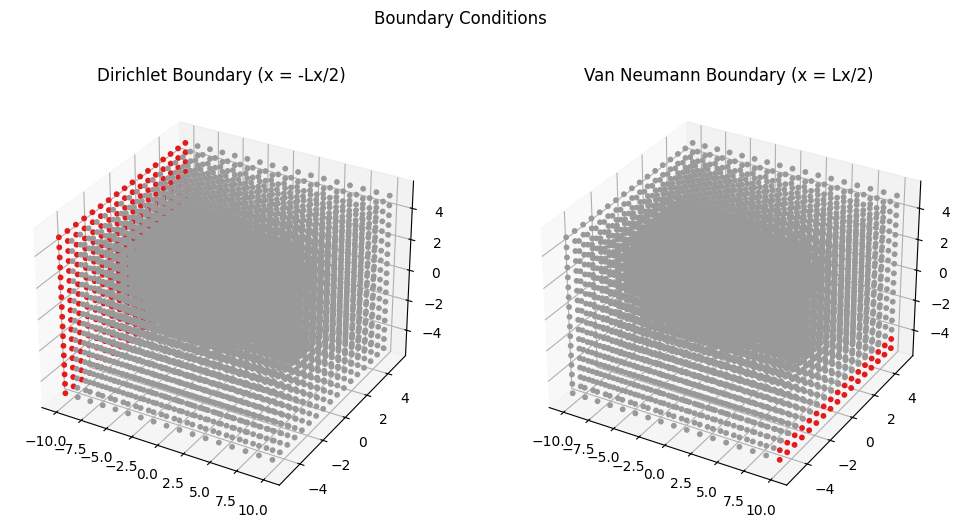

In [141]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + 1e-5
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 10),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 10),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [181]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [183]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-06 21:04:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 21:04:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 21:04:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 21:04:50][DEBUG] jax_fem: Done pre-computations, took 0.7119021415710449 [s]
[11-06 21:04:50][INFO] jax_fem: Solving a problem with 4096 cells, 4913x3 = 14739 dofs.
[11-06 21:04:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 21:04:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 21:04:50][DEBUG] jax_fem: Start timing
[11-06 21:04:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 21:04:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.3215 seconds
[11-06 21:04:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 21:04:51][DEBUG] jax_fem: Before, l_2 res = 10.87453977115239, relative l_2 re

Compliance: 138.3103


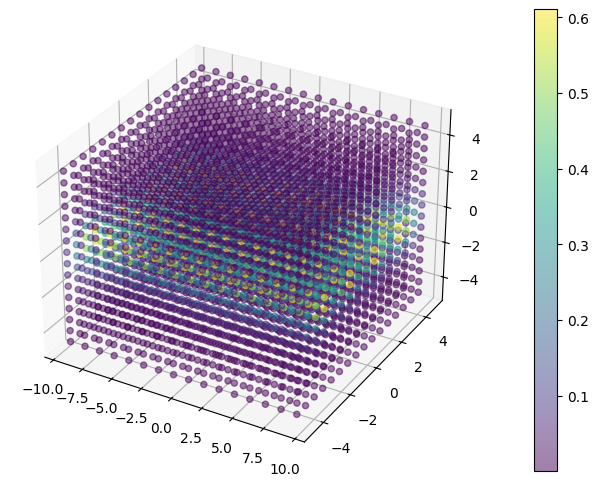

In [184]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [185]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)


def loss(
    cell_values: jnp.ndarray,
    mesh: dict,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    mesh = stop_grads_int(mesh)

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": cell_values,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [ ]:
# get the gradient of the loss w.r.t. rho
grad_loss = jax.grad(loss)
grad = grad_loss(
    jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1), adaptive_mesh
)
print("Grad shape:", grad.shape)
print(grad[0:100])

[11-06 21:05:06][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 21:05:06][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 21:05:06][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


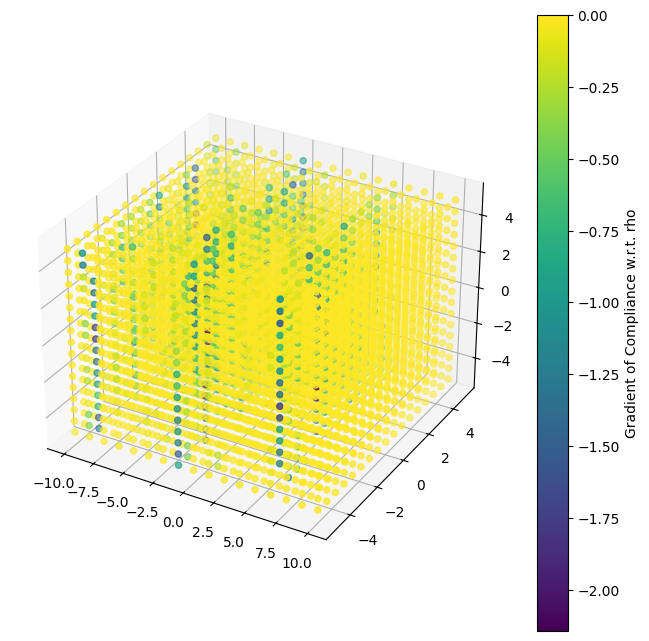

In [176]:
# print a 3D point cloud of the gradient field
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 8))
sc = ax.scatter(
    adaptive_mesh["points"][: adaptive_mesh["n_points"], 0],
    adaptive_mesh["points"][: adaptive_mesh["n_points"], 1],
    adaptive_mesh["points"][: adaptive_mesh["n_points"], 2],
    c=grad[:, 0][: adaptive_mesh["n_points"]],
    cmap="viridis",
)
# lets add a colorbar
plt.colorbar(sc, ax=ax, label="Gradient of Compliance w.r.t. rho")

In [ ]:
def loss(
    rho: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    max_points = 5000
    max_cells = 5000

    sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 4, scale=2.0)

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [88]:
# get grads of loss w.r.t. rho
grad_loss = jax.grad(loss)
grad = grad_loss(rho)

[11-06 17:31:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:31:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:31:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:31:33][DEBUG] jax_fem: Done pre-computations, took 0.455000638961792 [s]
[11-06 17:31:33][INFO] jax_fem: Solving a problem with 2563 cells, 3845x3 = 11535 dofs.
[11-06 17:31:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:31:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:31:35][DEBUG] jax_fem: Start timing
[11-06 17:31:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:31:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.3946 seconds
[11-06 17:31:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:31:35][DEBUG] jax_fem: Before, l_2 res = 638.3752163060713, relative l_2 res

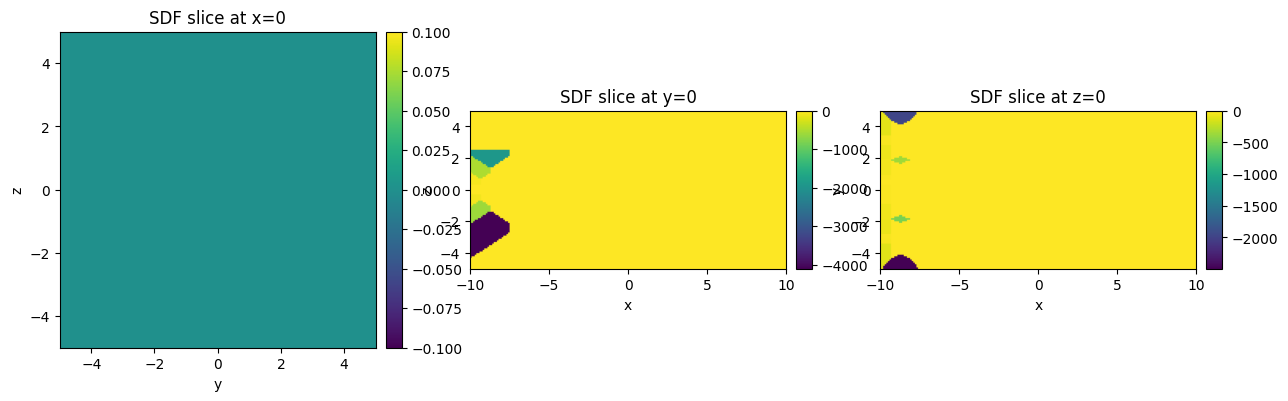

In [89]:
# plot the grad field
plot_grid(grad, Lx, Ly, Lz, Nx, Ny, Nz)

In [ ]:
def loss(
    params: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    max_points = 5000
    max_cells = 5000

    # -- Tess 1 (design) --
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
            "normalize_jacobian": True,
        },
    )["sdf"]

    # -- Local JAX code --
    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 4, scale=2.0)

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [65]:
import optax

optmizer = optax.adam(learning_rate=0.06)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss)

for i in range(60):
    loss_value, grads = grad_fn(params)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[..., 0].set(initial_params[..., 0])  # fix x-coordinates

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[11-06 17:06:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:06:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:06:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:06:09][DEBUG] jax_fem: Done pre-computations, took 0.1531810760498047 [s]
[11-06 17:06:09][INFO] jax_fem: Solving a problem with 771 cells, 1271x3 = 3813 dofs.
[11-06 17:06:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:06:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:06:09][DEBUG] jax_fem: Start timing
[11-06 17:06:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:06:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.3423 seconds
[11-06 17:06:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:06:10][DEBUG] jax_fem: Before, l_2 res = 644.4572637459538, relative l_2 res 

[[[ 0.16559178  0.99641883  0.47277877]
  [-0.05274899  0.1863435   0.05751782]
  [-0.13840742  0.07553026 -0.09772559]
  [-0.04920762 -0.31249484  0.0313438 ]]

 [[ 0.13666241  0.23033011  0.12271619]
  [-0.24975726 -0.14170457  0.0598229 ]
  [-0.24936695  0.08138833 -0.07320675]
  [-0.00628904 -0.0737607   0.05299881]]

 [[ 0.3771459  -0.2040568   0.2878275 ]
  [-0.09959895 -0.11140953 -0.0530954 ]
  [ 0.16705675 -0.01551021 -0.08939521]
  [-0.08136703 -0.02929826 -0.00442305]]

 [[ 0.5252784  -0.9702025   0.13368256]
  [ 0.25874224 -0.28756782 -0.15091997]
  [-0.04672447 -0.15485243 -0.18977186]
  [-0.11197761 -0.09203457 -0.05053905]]]
[[[-10.         -3.          0.       ]
  [ -3.3333333  -3.          0.       ]
  [  3.3333333  -3.          0.       ]
  [ 10.         -3.          0.       ]]

 [[-10.         -1.          0.       ]
  [ -3.3333333  -1.          0.       ]
  [  3.3333333  -1.          0.       ]
  [ 10.         -1.          0.       ]]

 [[-10.          1.         

[11-06 17:06:34][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:06:34][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:06:34][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:06:35][DEBUG] jax_fem: Done pre-computations, took 0.9917757511138916 [s]
[11-06 17:06:35][INFO] jax_fem: Solving a problem with 869 cells, 1362x3 = 4086 dofs.
[11-06 17:06:35][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:06:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:06:38][DEBUG] jax_fem: Start timing
[11-06 17:06:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:06:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.5075 seconds
[11-06 17:06:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:06:40][DEBUG] jax_fem: Before, l_2 res = 634.5402244040315, relative l_2 res 

[[[ 0.10182466  0.82598835  0.5937541 ]
  [-0.13752633  0.21902733  0.05401494]
  [-0.08098502 -0.09703416 -0.11295272]
  [-0.04057431 -0.08251273 -0.08998368]]

 [[-0.00641845 -0.19506799  0.2631697 ]
  [-0.06440506 -0.07455196 -0.10407583]
  [-0.03121321 -0.09378783 -0.10118953]
  [-0.080704   -0.12062986 -0.11828938]]

 [[-0.08107923  0.05631625  0.23951386]
  [-0.09255143 -0.17261605 -0.01773352]
  [-0.07566513 -0.06657136 -0.09541397]
  [-0.20676915 -0.0674295  -0.23936461]]

 [[-0.16022407 -1.1174868   0.05799359]
  [-0.08127736 -0.26226917 -0.07226642]
  [-0.07325435 -0.16799656 -0.07853507]
  [-0.0954024  -0.03574523 -0.09534466]]]
[[[-10.          -3.06        -0.06000001]
  [ -3.3333333   -3.06        -0.05999999]
  [  3.3333333   -3.06         0.05999999]
  [ 10.          -2.94        -0.05999998]]

 [[-10.          -1.06        -0.06      ]
  [ -3.3333333   -0.94        -0.05999999]
  [  3.3333333   -1.06         0.05999999]
  [ 10.          -0.94        -0.05999998]]

 [[-

[11-06 17:07:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:07:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:07:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:07:13][DEBUG] jax_fem: Done pre-computations, took 0.67449951171875 [s]
[11-06 17:07:13][INFO] jax_fem: Solving a problem with 876 cells, 1366x3 = 4098 dofs.
[11-06 17:07:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:07:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:07:13][DEBUG] jax_fem: Start timing
[11-06 17:07:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:07:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.3373 seconds
[11-06 17:07:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:07:14][DEBUG] jax_fem: Before, l_2 res = 634.5402244040315, relative l_2 res = 

[[[ 3.5036236e-01  1.0365514e+00  1.0129470e+00]
  [-5.6335069e-03  3.2303938e-01  2.4271430e-01]
  [ 3.1046344e-02 -2.6569320e-04  3.1101737e-02]
  [ 3.3020336e-02  3.1117385e-02  3.1000433e-02]]

 [[ 1.3658944e-02  5.8198161e-02  4.7511557e-01]
  [ 2.8690312e-02  4.2962171e-02  1.3568166e-01]
  [ 3.1144110e-02  3.1048579e-02  3.0371903e-02]
  [ 3.3878276e-04  3.3543052e-05 -8.9687192e-06]]

 [[ 1.9100633e-02  1.4114071e-01  4.3374375e-01]
  [ 2.9403873e-02  4.5877595e-02  1.0516691e-01]
  [-2.0291939e-06  3.2492824e-02 -7.7434129e-04]
  [ 3.0796025e-02  3.1128228e-02  3.1131506e-02]]

 [[-3.2563158e-04 -8.2848567e-01  2.3327702e-01]
  [ 5.7575859e-02 -1.3740309e-01  3.4282912e-02]
  [ 3.1139521e-02 -3.1849239e-03  3.1019803e-02]
  [ 3.0997425e-02  2.7327771e-05  4.4981680e-06]]]
[[[-10.          -3.119448    -0.11997027]
  [ -3.3333333   -3.1200573   -0.11987221]
  [  3.3333333   -3.0494475    0.12006937]
  [ 10.          -2.8897262   -0.03105294]]

 [[-10.          -1.0618094   -0.1

[11-06 17:07:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:07:36][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:07:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:07:37][DEBUG] jax_fem: Done pre-computations, took 0.7456517219543457 [s]
[11-06 17:07:37][INFO] jax_fem: Solving a problem with 869 cells, 1360x3 = 4080 dofs.
[11-06 17:07:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:07:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:07:37][DEBUG] jax_fem: Start timing
[11-06 17:07:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:07:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.3539 seconds
[11-06 17:07:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:07:38][DEBUG] jax_fem: Before, l_2 res = 637.3145937113176, relative l_2 res 

[[[ 3.09403479e-01  9.80361402e-01  1.21712470e+00]
  [-1.05312355e-02  2.07339779e-01  2.57077038e-01]
  [-3.66263484e-05 -1.54023280e-03  1.66807871e-03]
  [ 3.34911770e-03  5.27479642e-05 -1.78838469e-04]]

 [[ 6.15755375e-03  1.87967196e-02  6.02992654e-01]
  [-4.15988127e-03  1.27229271e-02  1.22151636e-01]
  [ 4.46779040e-06 -8.82610475e-05  1.25419523e-03]
  [ 5.57808962e-04  3.45958433e-05 -1.01667129e-05]]

 [[-7.78178964e-03  8.44920427e-02  4.64205742e-01]
  [-2.55898596e-03  1.26433261e-02  7.77394772e-02]
  [-8.82446420e-06 -2.52783997e-03  1.32931373e-03]
  [-2.74494290e-04 -5.04752279e-06 -5.22617984e-06]]

 [[ 3.42713930e-02 -7.66921461e-01  3.55954379e-01]
  [-1.56012631e-03 -1.44533232e-01  4.92538959e-02]
  [-6.90842671e-06  4.34635062e-04 -2.26710894e-04]
  [-3.02456552e-04 -6.44773681e-05  1.97823319e-05]]]
[[[-10.          -3.1792765   -0.17843649]
  [ -3.3333333   -3.179551    -0.17062458]
  [  3.3333333   -3.0412076    0.15770766]
  [ 10.          -2.8547204   -

[11-06 17:08:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:08:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:08:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:08:01][DEBUG] jax_fem: Done pre-computations, took 0.5149798393249512 [s]
[11-06 17:08:01][INFO] jax_fem: Solving a problem with 876 cells, 1366x3 = 4098 dofs.
[11-06 17:08:01][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:08:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:08:02][DEBUG] jax_fem: Start timing
[11-06 17:08:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:08:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.3358 seconds
[11-06 17:08:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:08:03][DEBUG] jax_fem: Before, l_2 res = 637.3145937113176, relative l_2 res 

[[[ 5.34459502e-02  7.94076800e-01  1.54341328e+00]
  [-2.23525465e-02  1.93936601e-01  2.89377034e-01]
  [-6.35847170e-03  3.88566055e-03  4.42692166e-04]
  [ 5.07408706e-03  2.27535595e-04 -2.10278624e-04]]

 [[ 2.37852395e-01 -8.86667296e-02  6.30347311e-01]
  [-6.29008003e-03  2.89567672e-02  1.55777022e-01]
  [ 1.65038909e-05 -2.65968638e-03  3.62032373e-03]
  [ 8.76661506e-04  4.91638893e-05 -3.36301782e-05]]

 [[-1.45061845e-02  8.84173885e-02  5.67833304e-01]
  [-4.17881506e-03  7.31028663e-03  9.86329764e-02]
  [ 1.52378097e-05 -6.66964392e-04 -3.37990117e-04]
  [-2.13270658e-04 -1.25008473e-05  5.29365707e-06]]

 [[-1.77439637e-02 -7.12376058e-01  4.40666944e-01]
  [-2.73050298e-03 -1.50472224e-01  6.59545809e-02]
  [-1.30669541e-05 -7.20364507e-04 -3.14335281e-04]
  [-4.62282711e-04 -2.37254681e-05 -1.70440835e-05]]]
[[[-1.0000000e+01 -3.2392104e+00 -2.3712249e-01]
  [-3.3333333e+00 -3.2385719e+00 -2.2465752e-01]
  [ 3.3333333e+00 -3.0340211e+00  1.8815516e-01]
  [ 1.0000000

[11-06 17:08:35][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:08:35][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:08:35][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:08:36][DEBUG] jax_fem: Done pre-computations, took 0.9686193466186523 [s]
[11-06 17:08:36][INFO] jax_fem: Solving a problem with 883 cells, 1380x3 = 4140 dofs.
[11-06 17:08:36][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:08:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:08:38][DEBUG] jax_fem: Start timing
[11-06 17:08:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:08:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.4846 seconds
[11-06 17:08:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:08:41][DEBUG] jax_fem: Before, l_2 res = 611.0347738656507, relative l_2 res 

[[[ 3.16605449e-01  7.12453723e-01  6.67634666e-01]
  [-1.04759960e-02  1.54555902e-01  1.48465335e-01]
  [-5.69875447e-05  3.12487944e-04  9.15605051e-04]
  [ 3.36462539e-03  5.43129790e-05 -1.63371500e-04]]

 [[-1.97694719e-01 -1.18426889e-01  6.18408263e-01]
  [ 2.09817174e-03  1.74037535e-02  9.36308950e-02]
  [-1.23029658e-05  1.93509329e-02  1.89168211e-02]
  [ 7.93790270e-04  5.33429884e-05 -5.12145125e-05]]

 [[ 4.55294587e-02 -1.06423035e-01  4.52573895e-01]
  [ 2.47550663e-03  9.00129043e-03  9.70046520e-02]
  [ 4.52015593e-05  1.74000766e-02  1.31569058e-02]
  [ 4.09243148e-05  1.47318235e-06  9.50605863e-06]]

 [[ 1.77335888e-02 -7.10258186e-01  4.90257710e-01]
  [-4.22175415e-03 -1.45201266e-01  8.62224922e-02]
  [ 5.10014979e-05 -3.48860212e-03 -4.27747960e-04]
  [-5.23523835e-04 -1.77097554e-05  5.35618674e-05]]]
[[[-1.0000000e+01 -3.2985232e+00 -2.9598340e-01]
  [-3.3333333e+00 -3.2970941e+00 -2.8076676e-01]
  [ 3.3333333e+00 -3.0289855e+00  2.1379501e-01]
  [ 1.0000000

[11-06 17:09:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:09:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:09:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:09:31][DEBUG] jax_fem: Done pre-computations, took 1.04134202003479 [s]
[11-06 17:09:31][INFO] jax_fem: Solving a problem with 904 cells, 1410x3 = 4230 dofs.
[11-06 17:09:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:09:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:09:33][DEBUG] jax_fem: Start timing
[11-06 17:09:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:09:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.5025 seconds
[11-06 17:09:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:09:36][DEBUG] jax_fem: Before, l_2 res = 577.0401958037604, relative l_2 res = 

[[[ 2.18024239e-01  3.49782348e-01  2.40665823e-01]
  [-5.13117807e-03  6.12396225e-02  6.40056133e-02]
  [-8.26284231e-05  2.40772404e-03  1.35284103e-03]
  [ 1.56609481e-03 -2.62608319e-05 -1.37222771e-04]]

 [[-1.22909442e-01 -1.89127792e-02  3.89088690e-01]
  [-5.21947164e-03  4.54533435e-02  6.31779805e-02]
  [ 9.09055962e-06 -1.46990747e-03  6.93261856e-04]
  [-1.48962636e-03  3.51373492e-05  1.03049051e-05]]

 [[ 1.22045614e-01 -1.54023364e-01  1.92704752e-01]
  [ 2.21665297e-02  5.96097577e-03  1.01222441e-01]
  [ 2.57132197e-05 -2.37397780e-03  4.55998965e-02]
  [-1.62543450e-03  2.40761638e-05  2.48266442e-05]]

 [[-3.20277996e-02 -6.47511482e-01  5.65681338e-01]
  [-5.33431908e-03 -1.42491862e-01  8.62957090e-02]
  [ 3.92166976e-06 -7.06994301e-03 -3.31770105e-04]
  [-4.45169921e-04 -7.91249695e-05  1.16821393e-05]]]
[[[-1.0000000e+01 -3.3570356e+00 -3.5337037e-01]
  [-3.3333333e+00 -3.3543959e+00 -3.3637992e-01]
  [ 3.3333333e+00 -3.0247252e+00  2.3570442e-01]
  [ 1.0000000

[11-06 17:10:25][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:10:25][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:10:25][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:10:26][DEBUG] jax_fem: Done pre-computations, took 1.0245118141174316 [s]
[11-06 17:10:26][INFO] jax_fem: Solving a problem with 904 cells, 1413x3 = 4239 dofs.
[11-06 17:10:26][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:10:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:10:27][DEBUG] jax_fem: Start timing
[11-06 17:10:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:10:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.3278 seconds
[11-06 17:10:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:10:28][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res 

[[[ 3.1959003e-01  1.8289772e-01 -3.7987309e-03]
  [-2.0181971e-04  2.7333060e-02 -1.3561307e-02]
  [-4.6135734e-05 -3.6675159e-03 -1.5058716e-04]
  [ 1.6145510e-05 -3.7946433e-05 -5.4889653e-05]]

 [[ 4.2769708e-02 -5.7509914e-02  5.1481299e-02]
  [-3.7522896e-04 -1.2027927e-02  1.4504471e-03]
  [ 2.6920316e-06  1.6880056e-05  3.6075231e-04]
  [ 2.0522405e-04  1.2331271e-05 -1.0390354e-06]]

 [[ 3.5359349e-02 -2.5713695e-02  5.7950892e-02]
  [ 6.8466610e-04 -1.0555845e-02 -9.8186051e-03]
  [-2.9667638e-06 -1.3515541e-04  5.9557734e-03]
  [-2.3845494e-05  8.1569005e-06 -9.8984901e-07]]

 [[-1.1048673e-02 -3.1364402e-01  2.5813198e-01]
  [-7.2028645e-04 -4.8083752e-02  2.8159920e-02]
  [ 3.7463225e-05  3.1640456e-04  4.6188375e-03]
  [-6.1057239e-05 -3.1437710e-05 -1.8047151e-06]]]
[[[-1.0000000e+01 -3.4122748e+00 -4.0623924e-01]
  [-3.3333333e+00 -3.4075480e+00 -3.8849741e-01]
  [ 3.3333333e+00 -3.0216014e+00  2.5456715e-01]
  [ 1.0000000e+01 -2.7627637e+00  3.6280192e-03]]

 [[-1.0000

[11-06 17:11:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:11:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:11:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:11:10][DEBUG] jax_fem: Done pre-computations, took 1.0441017150878906 [s]
[11-06 17:11:10][INFO] jax_fem: Solving a problem with 911 cells, 1432x3 = 4296 dofs.
[11-06 17:11:10][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:11:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:11:12][DEBUG] jax_fem: Start timing
[11-06 17:11:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:11:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.5292 seconds
[11-06 17:11:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:11:15][DEBUG] jax_fem: Before, l_2 res = 570.2656765881419, relative l_2 res 

[[[ 2.3986374e-01  1.3237332e-01  1.8288273e-02]
  [ 1.7508888e-04  2.7663901e-02 -2.1262797e-02]
  [-2.3239609e-06  4.5508397e-04  3.9769115e-04]
  [-4.3317898e-05 -3.7232303e-06  2.1127278e-05]]

 [[ 7.5427793e-02 -7.3188610e-02  1.4638170e-02]
  [-3.7423978e-04 -3.4434325e-03  8.7940479e-03]
  [ 9.4538746e-06 -3.4105222e-04  6.3285851e-03]
  [ 1.7873617e-04  1.3851956e-05 -1.3845860e-05]]

 [[ 2.3061266e-02 -3.8094550e-02  3.5081334e-02]
  [ 9.2256314e-04 -1.3034881e-02 -7.9760076e-03]
  [-2.6239807e-06  1.0488134e-04  1.4045176e-03]
  [-2.5126119e-05  3.2434973e-06  5.2028304e-07]]

 [[-6.8489015e-03 -3.0043164e-01  2.7557033e-01]
  [-2.8242078e-03 -5.7651907e-02  3.3110891e-02]
  [ 2.3240422e-05  6.0697715e-04 -4.4939289e-04]
  [-6.4048567e-05 -1.8900571e-05  3.1977052e-05]]]
[[[-1.0000000e+01 -3.4632454e+00 -4.5279995e-01]
  [-3.3333333e+00 -3.4558432e+00 -4.3360183e-01]
  [ 3.3333333e+00 -3.0179598e+00  2.7122521e-01]
  [ 1.0000000e+01 -2.7466989e+00  8.1254998e-03]]

 [[-1.0000

[11-06 17:11:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:11:57][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:11:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:11:58][DEBUG] jax_fem: Done pre-computations, took 0.9749276638031006 [s]
[11-06 17:11:58][INFO] jax_fem: Solving a problem with 897 cells, 1421x3 = 4263 dofs.
[11-06 17:11:58][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:12:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:12:00][DEBUG] jax_fem: Start timing
[11-06 17:12:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:12:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.5132 seconds
[11-06 17:12:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:12:03][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 2.52664953e-01  1.08695298e-01 -5.54219075e-02]
  [ 9.09215072e-04  1.88708808e-02 -2.06467062e-02]
  [-4.81071766e-05  1.84627483e-04  8.35713174e-04]
  [-3.52115050e-04 -5.83948895e-05 -1.38656906e-05]]

 [[ 1.40752792e-01 -5.10564968e-02  1.70272272e-02]
  [ 5.89646188e-05 -1.02186967e-02 -5.66539587e-03]
  [ 1.13707865e-05 -7.52493215e-04 -7.73207401e-04]
  [ 8.57367631e-05  1.92961197e-05  8.21849198e-07]]

 [[ 2.90970169e-02  3.22579481e-02  2.35121384e-01]
  [-1.11521559e-03  1.45508768e-02  2.67986972e-02]
  [ 2.55385112e-05  5.51861631e-05  5.76650770e-03]
  [ 5.62017485e-05  8.89840862e-07  1.86570969e-06]]

 [[ 6.67703673e-02 -9.44188535e-02  6.43575117e-02]
  [ 1.71759096e-03 -1.43457707e-02 -1.03402650e-02]
  [-2.28425615e-05  1.68704018e-02  2.65448983e-03]
  [ 2.37107932e-04 -4.63694305e-05 -3.99276323e-05]]]
[[[-10.          -3.5101514   -0.49435243]
  [ -3.3333333   -3.5001543   -0.4723338 ]
  [  3.3333333   -3.0148358    0.28593642]
  [ 10.          -2.7324371    

[11-06 17:12:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:12:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:12:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:12:48][DEBUG] jax_fem: Done pre-computations, took 1.0916080474853516 [s]
[11-06 17:12:48][INFO] jax_fem: Solving a problem with 918 cells, 1442x3 = 4326 dofs.
[11-06 17:12:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:12:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:12:50][DEBUG] jax_fem: Start timing
[11-06 17:12:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:12:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.5276 seconds
[11-06 17:12:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:12:53][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 1.80294633e-01  7.60074928e-02 -1.09232925e-01]
  [ 1.88723789e-03  1.33830234e-02 -2.86631342e-02]
  [-7.58630122e-05 -6.37271267e-04  1.91060011e-04]
  [-6.55904587e-04 -6.42387677e-05  1.03975408e-05]]

 [[ 9.92905572e-02 -4.89333533e-02 -4.79704626e-02]
  [ 1.98149960e-03 -4.12107538e-03 -2.70156898e-02]
  [ 1.30177532e-05  3.83452186e-03  4.00748057e-03]
  [-2.92836281e-04 -1.52199573e-05  4.37293565e-05]]

 [[ 7.79508846e-03  2.62699109e-02  1.35112777e-01]
  [-6.15779485e-04  6.82750111e-03  1.23559786e-02]
  [-4.77350204e-06  7.23530713e-04  2.37648585e-03]
  [ 6.89059516e-06 -2.17421757e-06 -6.16232091e-06]]

 [[ 5.39034829e-02 -6.78556263e-02  5.84321693e-02]
  [ 2.27134628e-03 -2.70956341e-04 -3.23332511e-02]
  [ 5.26157746e-05 -2.06167562e-04  4.80170175e-03]
  [ 2.65122915e-04  7.77145324e-05  7.98116275e-07]]]
[[[-10.          -3.5533772   -0.5307664 ]
  [ -3.3333333   -3.5406866   -0.5056476 ]
  [  3.3333333   -3.0120916    0.29890576]
  [ 10.          -2.7197037    

[11-06 17:13:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:13:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:13:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:13:34][DEBUG] jax_fem: Done pre-computations, took 0.9867947101593018 [s]
[11-06 17:13:34][INFO] jax_fem: Solving a problem with 932 cells, 1464x3 = 4392 dofs.
[11-06 17:13:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:13:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:13:37][DEBUG] jax_fem: Start timing
[11-06 17:13:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:13:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.4998 seconds
[11-06 17:13:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:13:39][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 1.82222024e-01  5.21736965e-02 -1.35638237e-01]
  [ 2.91308877e-03  7.66889565e-03 -3.39946523e-02]
  [-5.52874772e-05  3.57812061e-03  1.17752395e-04]
  [-9.94836329e-04 -7.25474092e-05  5.28888559e-05]]

 [[ 3.69174071e-02 -4.14863192e-02 -1.24951661e-01]
  [ 3.26209725e-03 -6.29614759e-03 -4.08719108e-02]
  [ 1.41442997e-05 -2.99417647e-04 -1.94697393e-04]
  [-5.73395344e-04 -2.53920552e-05  3.44594191e-05]]

 [[ 1.20042292e-02  4.27021272e-03  8.91011879e-02]
  [ 4.68027383e-06  2.19392125e-03 -9.64724645e-03]
  [ 1.34505444e-05 -5.09523943e-06  1.30309534e-04]
  [-9.51252696e-06  5.96852897e-06  4.59763578e-06]]

 [[ 9.49703995e-03 -3.92673500e-02  2.26342883e-02]
  [ 6.41760556e-03 -1.54285156e-03 -4.03810479e-02]
  [ 3.74811316e-05  3.80929734e-04  2.98087182e-03]
  [ 3.94730159e-04  2.19198901e-05  3.26835834e-05]]]
[[[-10.          -3.5930765   -0.5620713 ]
  [ -3.3333333   -3.5777128   -0.5337645 ]
  [  3.3333333   -3.009482     0.31049234]
  [ 10.          -2.7082863    

[11-06 17:14:15][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:14:15][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:14:15][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:14:16][DEBUG] jax_fem: Done pre-computations, took 1.0307164192199707 [s]
[11-06 17:14:16][INFO] jax_fem: Solving a problem with 939 cells, 1477x3 = 4431 dofs.
[11-06 17:14:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:14:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:14:19][DEBUG] jax_fem: Start timing
[11-06 17:14:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:14:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.5277 seconds
[11-06 17:14:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:14:21][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 1.3824378e-01  2.8202794e-02 -1.7348890e-01]
  [ 4.0780716e-03  2.3034494e-03 -4.6000645e-02]
  [ 5.8177120e-05  1.3249277e-04  3.4834346e-04]
  [-1.2743787e-03  3.6216788e-05  1.7304804e-04]]

 [[ 6.0280818e-02 -1.8717377e-02 -1.7299069e-01]
  [ 4.4471635e-03 -4.1867155e-03 -5.2604970e-02]
  [ 1.8229046e-05  2.6458429e-04 -2.5443265e-03]
  [-8.1018661e-04 -3.7002268e-05  6.0779912e-05]]

 [[ 2.9135266e-02  8.0964770e-03  5.6706004e-02]
  [-3.5128377e-03 -6.6091493e-04 -9.8339431e-03]
  [-6.6724501e-06 -2.2251436e-03 -1.2558614e-03]
  [-9.7120545e-05 -6.4571227e-06  2.4754240e-07]]

 [[ 5.7091764e-03 -1.3465884e-02 -4.3991148e-02]
  [ 4.1819927e-03  1.3604125e-03 -4.7978051e-02]
  [ 3.1023208e-06 -1.4185351e-03  6.1969473e-03]
  [ 4.1668813e-04  4.9643433e-05  9.1569436e-06]]]
[[[-10.          -3.6294358   -0.5885698 ]
  [ -3.3333333   -3.611409    -0.55699   ]
  [  3.3333333   -3.0079799    0.32088783]
  [ 10.          -2.698014     0.02171469]]

 [[-10.          -0.94983447  -0.6

[11-06 17:14:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:14:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:14:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:14:59][DEBUG] jax_fem: Done pre-computations, took 1.0528569221496582 [s]
[11-06 17:14:59][INFO] jax_fem: Solving a problem with 946 cells, 1487x3 = 4461 dofs.
[11-06 17:14:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:15:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:15:02][DEBUG] jax_fem: Start timing
[11-06 17:15:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:15:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.5619 seconds
[11-06 17:15:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:15:04][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 1.12946145e-01  1.30274321e-03 -2.13354006e-01]
  [ 4.94357524e-03 -2.53761187e-03 -5.30221947e-02]
  [-4.91483952e-05 -1.99185903e-04  3.02734901e-04]
  [-1.68404554e-03 -1.32404079e-04  7.52800188e-05]]

 [[ 7.06254840e-02 -1.18166544e-02 -2.16584310e-01]
  [ 5.63834189e-03 -8.19390349e-04 -6.58482835e-02]
  [ 1.28449374e-05  2.56238808e-03  2.49930844e-03]
  [-1.05663447e-03 -5.59388282e-05  6.93413604e-05]]

 [[ 1.70194617e-04 -4.10550535e-02  1.60144791e-02]
  [ 1.75676867e-03 -4.94909985e-03 -2.01740898e-02]
  [-3.59873320e-06 -1.55426125e-04 -3.03676818e-03]
  [-1.52712411e-04 -7.61983119e-06 -2.34432719e-06]]

 [[ 3.62081043e-02 -4.87868004e-02 -9.10755694e-02]
  [ 5.41046308e-03 -1.00145210e-02 -6.79874867e-02]
  [-4.17497395e-05 -6.40298938e-03  1.65098936e-05]
  [ 4.90854378e-04 -1.95694483e-05  1.15499170e-05]]]
[[[-10.          -3.6625762   -0.6103465 ]
  [ -3.3333333   -3.6419086   -0.57514465]
  [  3.3333333   -3.0066571    0.33019295]
  [ 10.          -2.688757     

[11-06 17:15:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:15:36][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:15:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:15:36][DEBUG] jax_fem: Done pre-computations, took 0.1802051067352295 [s]
[11-06 17:15:36][INFO] jax_fem: Solving a problem with 939 cells, 1477x3 = 4431 dofs.
[11-06 17:15:36][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:15:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:15:36][DEBUG] jax_fem: Start timing
[11-06 17:15:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:15:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.3731 seconds
[11-06 17:15:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:15:37][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 9.61389542e-02 -2.60356683e-02 -2.40053236e-01]
  [ 5.82620362e-03 -6.06644107e-03 -5.72078861e-02]
  [-1.72881319e-05  8.15743580e-04  1.83048673e-04]
  [-1.91457383e-03 -8.94551558e-05  1.18979435e-04]]

 [[ 4.87807766e-02 -1.61071289e-02 -2.73909330e-01]
  [ 6.70454139e-03 -2.12489907e-03 -7.48747960e-02]
  [ 2.52171230e-06  1.20013638e-03  1.00265793e-03]
  [-1.24760228e-03 -8.10776328e-05  6.46833578e-05]]

 [[ 7.90207535e-02 -1.81595664e-02  3.68345752e-02]
  [ 8.75280425e-03 -7.46347662e-03 -2.54676398e-02]
  [ 1.99000278e-04  5.97547973e-03  7.41242105e-03]
  [ 3.32625823e-05  4.45469459e-06  1.26898312e-05]]

 [[ 5.00825755e-02 -1.70082059e-02 -1.55628070e-01]
  [ 8.59076250e-03  6.69005653e-03 -8.64572600e-02]
  [ 2.21142454e-05 -1.28833257e-04 -3.88552653e-05]
  [ 8.08805111e-04 -2.44976974e-07 -7.03111727e-05]]]
[[[-10.          -3.6925328   -0.62742245]
  [ -3.3333333   -3.6693265   -0.58835495]
  [  3.3333333   -3.005415     0.33854145]
  [ 10.          -2.680382     

[11-06 17:15:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:15:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:15:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:15:59][DEBUG] jax_fem: Done pre-computations, took 1.0644476413726807 [s]
[11-06 17:15:59][INFO] jax_fem: Solving a problem with 932 cells, 1471x3 = 4413 dofs.
[11-06 17:15:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:16:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:16:00][DEBUG] jax_fem: Start timing
[11-06 17:16:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:16:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.3549 seconds
[11-06 17:16:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:16:01][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 6.5087400e-02 -4.6986256e-02 -2.6073349e-01]
  [ 6.4829867e-03 -1.2680230e-02 -6.0321622e-02]
  [ 3.1836506e-05 -2.8328672e-03 -2.8415709e-03]
  [-2.1118631e-03 -1.7641635e-04  1.4994753e-04]]

 [[ 2.8554931e-02 -1.9547407e-02 -3.0813736e-01]
  [ 9.6986666e-03  1.6151720e-03 -8.3114028e-02]
  [ 4.0329742e-05  9.8810752e-04  7.8893994e-04]
  [-1.3761324e-03 -7.3307339e-05  1.1350002e-04]]

 [[ 9.0257851e-03 -6.3242182e-02 -4.4461161e-02]
  [ 3.2450955e-03 -9.8162973e-03 -2.4411125e-02]
  [ 4.8098100e-06  3.7483338e-04  2.9796493e-04]
  [-1.4412907e-03  1.1365645e-05  1.4141013e-05]]

 [[ 4.4795085e-02 -8.2078120e-03 -1.9096135e-01]
  [ 7.2794091e-03 -2.0030758e-03 -1.0202761e-01]
  [ 1.5346624e-05 -3.1957374e-04 -2.4107874e-03]
  [ 9.8032609e-04  2.5755888e-05 -5.4928554e-05]]]
[[[-10.          -3.719301    -0.6399614 ]
  [ -3.3333333   -3.6938114   -0.59689325]
  [  3.3333333   -3.0044851    0.3460614 ]
  [ 10.          -2.6727948    0.02849738]]

 [[-10.          -0.88421607  -0.6

[11-06 17:16:34][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:16:34][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:16:34][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:16:35][DEBUG] jax_fem: Done pre-computations, took 1.0322182178497314 [s]
[11-06 17:16:35][INFO] jax_fem: Solving a problem with 939 cells, 1478x3 = 4434 dofs.
[11-06 17:16:35][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:16:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:16:36][DEBUG] jax_fem: Start timing
[11-06 17:16:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:16:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.3524 seconds
[11-06 17:16:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:16:38][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

[[[ 8.34078193e-02 -6.64326847e-02 -2.62612760e-01]
  [ 7.01967906e-03 -1.28873223e-02 -6.32392243e-02]
  [ 5.22449263e-05 -9.97981624e-05  1.53349727e-04]
  [-2.20255740e-03 -1.14610775e-04  1.61875621e-04]]

 [[ 4.37622257e-02  2.07412802e-02 -3.01124811e-01]
  [ 8.26564617e-03 -5.48516959e-03 -9.64228287e-02]
  [-7.13073541e-06  2.38098655e-05  3.64643545e-03]
  [-1.49964972e-03 -1.05612533e-04  8.04677547e-05]]

 [[ 4.91087921e-02 -5.77121489e-02 -4.02946249e-02]
  [ 3.68826021e-03 -1.62481386e-02 -2.48226337e-02]
  [-1.08322286e-06  5.41005982e-04 -1.71228603e-03]
  [-1.59038813e-04 -2.06821551e-05 -1.51423119e-05]]

 [[ 5.47565892e-02  5.21440478e-03 -2.08574831e-01]
  [ 1.07133826e-02  6.56743301e-03 -1.08814374e-01]
  [ 9.10416838e-06 -1.46499791e-04  5.07414843e-05]
  [ 1.21219852e-03 -2.28729223e-05 -6.93057664e-05]]]
[[[-10.          -3.7429366   -0.648172  ]
  [ -3.3333333   -3.7153082   -0.6010566 ]
  [  3.3333333   -3.002963     0.3534256 ]
  [ 10.          -2.6659029    

[11-06 17:17:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:17:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:17:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:17:13][DEBUG] jax_fem: Done pre-computations, took 1.045093059539795 [s]
[11-06 17:17:13][INFO] jax_fem: Solving a problem with 932 cells, 1468x3 = 4404 dofs.
[11-06 17:17:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:17:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:17:13][DEBUG] jax_fem: Start timing
[11-06 17:17:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:17:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.3606 seconds
[11-06 17:17:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:17:15][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res =

[[[ 5.86258546e-02 -8.52794200e-02 -2.57189244e-01]
  [ 7.22214673e-03 -1.53085189e-02 -6.34010211e-02]
  [ 6.25632092e-05 -2.38918830e-04  2.15929220e-04]
  [-2.30145571e-03 -1.07489206e-04  1.84066841e-04]]

 [[ 5.75225838e-02  2.93946738e-04 -3.34856212e-01]
  [ 8.68649036e-03 -1.55304116e-03 -9.66514498e-02]
  [ 1.08366576e-05 -4.49694600e-03 -4.82505606e-03]
  [-1.51441933e-03 -1.32260422e-04  9.99029216e-05]]

 [[ 3.12163513e-02 -7.49280453e-02 -1.48316994e-02]
  [ 5.63271018e-03 -1.80436242e-02 -3.35747525e-02]
  [-1.63845925e-05  2.11216742e-03  2.87371175e-03]
  [-1.63412988e-04 -1.14649765e-05 -1.64858775e-05]]

 [[ 5.82641251e-02  6.63964916e-03 -2.27797538e-01]
  [ 1.13002164e-02  9.17751808e-03 -1.15622252e-01]
  [ 3.25562978e-05 -2.13310565e-03  2.38601048e-03]
  [ 1.40908209e-03 -3.15192046e-05 -1.46997976e-04]]]
[[[-10.          -3.7634914   -0.65246016]
  [ -3.3333333   -3.7341034   -0.6011147 ]
  [  3.3333333   -3.001558     0.36007714]
  [ 10.          -2.6596391    

[11-06 17:17:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:17:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:17:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:17:45][DEBUG] jax_fem: Done pre-computations, took 1.0946543216705322 [s]
[11-06 17:17:45][INFO] jax_fem: Solving a problem with 932 cells, 1469x3 = 4407 dofs.
[11-06 17:17:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:17:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:17:45][DEBUG] jax_fem: Start timing
[11-06 17:17:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:17:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.3543 seconds
[11-06 17:17:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:17:47][DEBUG] jax_fem: Before, l_2 res = 579.8840952852938, relative l_2 res 

[[[ 5.94950877e-02 -9.54926610e-02 -2.43018210e-01]
  [ 7.12494366e-03 -1.82824247e-02 -6.05508648e-02]
  [ 4.35632501e-05 -6.04928646e-04  2.30587786e-04]
  [-2.23039882e-03 -1.02206854e-04  1.55561938e-04]]

 [[ 1.05799660e-01  1.96400687e-01 -3.58614653e-01]
  [ 1.04710143e-02  3.42238694e-02 -9.90294665e-02]
  [ 3.71657807e-05 -5.60147827e-03 -6.19476289e-03]
  [-2.05607922e-03 -2.06172292e-04  1.14113835e-04]]

 [[ 1.12378215e-02 -8.48793387e-02  5.90671692e-03]
  [ 2.52203085e-03 -1.66548304e-02 -2.52205990e-02]
  [ 6.75943875e-06  6.92513595e-06  2.34729284e-03]
  [-6.63672836e-05 -4.82157884e-06  1.36433555e-05]]

 [[ 4.50983346e-02  6.12952933e-03 -1.99756727e-01]
  [ 1.00875683e-02  5.71519835e-03 -9.91642624e-02]
  [-2.82454312e-05 -7.41694705e-04 -3.50234659e-05]
  [ 1.37080951e-03 -4.80743511e-05 -1.37047158e-04]]]
[[[-10.          -3.7810054   -0.65326715]
  [ -3.3333333   -3.750323    -0.5974633 ]
  [  3.3333333   -3.0002236    0.3660752 ]
  [ 10.          -2.653941     

[11-06 17:18:15][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 17:18:15][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 17:18:15][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 17:18:16][DEBUG] jax_fem: Done pre-computations, took 1.0830111503601074 [s]
[11-06 17:18:16][INFO] jax_fem: Solving a problem with 932 cells, 1474x3 = 4422 dofs.
[11-06 17:18:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-06 17:18:16][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 17:18:16][DEBUG] jax_fem: Start timing
[11-06 17:18:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 17:18:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.3501 seconds
[11-06 17:18:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 17:18:18][DEBUG] jax_fem: Before, l_2 res = 575.1779032276258, relative l_2 res 

JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_232537/2865848482.py", line 13, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 505, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/tree_util.py", line 488, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2105, in _vjp_pullback_wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/tree_util.py", line 488, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 320, in unbound_vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 438, in backward_pass
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 169, in tesseract_dispatch_transpose_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 253, in vector_jacobian_product
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 448, in vector_jacobian_product
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 667, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/runtime/core.py", line 215, in vector_jacobian_product
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/hot_design_tess/tesseract_api.py", line 305, in vector_jacobian_product
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/hot_design_tess/tesseract_api.py", line 227, in jac_sdf_wrt_params
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/hot_design_tess/tesseract_api.py", line 174, in apply_fn
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/hot_design_tess/tesseract_api.py", line 149, in compute_sdf
KeyboardInterrupt: 

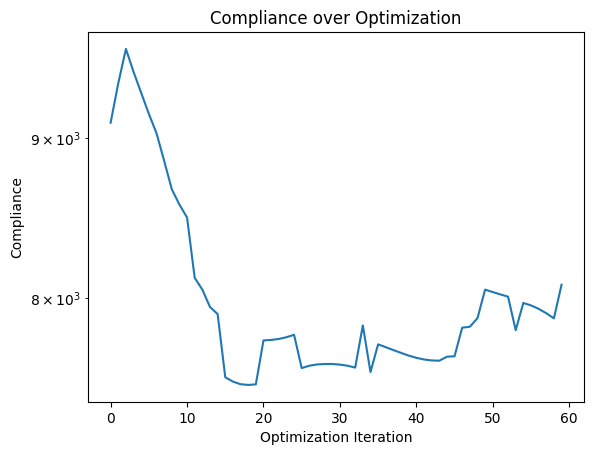

In [25]:
plt.plot(loss_hist)
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization");

In [33]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

ims = []
for params in params_hist:
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
        },
    )["sdf"]

    rho = sdf_to_rho(sdf)

    im = plt.imshow(
        sdf[:, :, Nz // 2].T, origin="lower", cmap="viridis", vmin=0, vmax=1
    )
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_x.gif", writer="pillow", fps=10)

In [26]:
# lets visualize the 3d meshes over the optimization
for i, params in enumerate(params_hist):
    design_out = design_tess.apply(
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        }
    )
    surface_mesh = design_out["mesh"]

    num_vertices = surface_mesh["n_points"]
    num_faces = surface_mesh["n_faces"]

    points = surface_mesh["points"][:num_vertices]
    faces = surface_mesh["faces"][:num_faces]

    mesh = {
        "points": points,
        "faces": faces,
    }

    plot_mesh(mesh, save_path=f"tmp_img/mesh_optim_{i:03d}.png")